In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
import matplotlib.patches as mpatches
from scipy.stats import shapiro

or_dir = '../data' #original data (demux sequences, metadata)
data_dir = 'data' #data from polybox (ASV, taxonomy analysis)


In [10]:
#fill the NAs in the metadata diet else get error in longitudinal analysis
metadata_fillna = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')
metadata_fillna['diet_weaning'] = metadata_fillna['diet_weaning'].fillna("weaned")
metadata_fillna['diet_milk'] = metadata_fillna['diet_milk'].fillna("weaned")
metadata_fillna.head(10)
#save the modified metadata file as a new file
metadata_fillna.to_csv("data/metadata_fillna.tsv", sep = "\t", index = False)

# Getting data from polybox

In [34]:
! wget -nv -O $data_dir/phylogeny_filtered_table.qza 'https://polybox.ethz.ch/index.php/s/YD03e961xKim9Ix/download'
! wget -nv -O $data_dir/reference-tree.qza 'https://polybox.ethz.ch/index.php/s/6npnNErzece0gdn/download'

2022-11-30 10:10:51 URL:https://polybox.ethz.ch/index.php/s/YD03e961xKim9Ix/download [1799985/1799985] -> "data/phylogeny_filtered_table.qza" [1]
2022-11-30 10:10:52 URL:https://polybox.ethz.ch/index.php/s/6npnNErzece0gdn/download [2808287/2808287] -> "data/reference-tree.qza" [1]


In [2]:
! pwd

/home/jovyan/HelicopterBaby/Phylogeny, alpha and beta diversity


# Running the standard alpha diversity analysis

First to create the metadata file to be used here for better running and get an overview of the feature table.

In [36]:
# deleting the collection data column as it is crashing the diversity core-metrics visualization
metadata_no_collection_data = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')
del metadata_no_collection_data['collection_date']
metadata_no_collection_data.to_csv(data_dir+"/new_metadata_for_a_diversity.tsv", sep = "\t", index = False)

In [37]:
! qiime feature-table summarize \
  --i-table $data_dir/phylogeny_filtered_table.qza \
  --m-sample-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --o-visualization $data_dir/feature-table2.qzv
#$or_dir/metadata.tsv \

Saved Visualization to: data/feature-table2.qzv


In [3]:
Visualization.load(f'{data_dir}/feature-table2.qzv')

<visualization: Visualization uuid: ec7eb5c1-9383-4dd7-a640-fe31c773c5eb>

From this step, we find the rarefaction depth for the alpha diversity.

In [52]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/phylogeny_filtered_table.qza \
    --i-phylogeny $data_dir/reference-tree.qza \
    --p-max-depth 10000 \
    --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
    --o-visualization $data_dir/alpha-rarefaction2.qzv

^C

Aborted!


Chose 10k max depth, and since graphs level off before that, this makes sense.

In [4]:
Visualization.load(f'{data_dir}/alpha-rarefaction2.qzv')

<visualization: Visualization uuid: b312c943-b7f1-45c0-a863-95a4aa5e468b>

Running diversity plugin

In [53]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/phylogeny_filtered_table.qza \
  --i-phylogeny $data_dir/reference-tree.qza \
  --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --p-sampling-depth 8000 \
  --output-dir $data_dir/core-metrics-results2

Saved FeatureTable[Frequency] to: data/core-metrics-results2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results2/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results2/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results2/evenness_vector.qza
Saved DistanceMatrix to: data/core-metrics-results2/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results2/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: data/core-metrics-results2/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: data/core-metrics-results2/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: data/core-metrics-results2/jaccard_pcoa_re

In [ ]:
! pwd

Statistical test for the categorical columns and alpha diversity

In [54]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --o-visualization $data_dir/core-metrics-results2/faith-pd-group-significance.qzv

Saved Visualization to: data/core-metrics-results2/faith-pd-group-significance.qzv


In [8]:
Visualization.load(f'{data_dir}/core-metrics-results2/faith-pd-group-significance.qzv')

<visualization: Visualization uuid: 6c56409e-378a-468e-a72d-8b899cfa29c3>

Statistical test for continuous metadata columns and alpha diversity. From here we can see a obvious trend for the correlation of age and alpha diversity.

In [6]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --o-visualization $data_dir/core-metrics-results2/faith-pd-group-significance-numeric.qzv

Saved Visualization to: data/core-metrics-results2/faith-pd-group-significance-numeric.qzv


In [7]:
Visualization.load(f'{data_dir}/core-metrics-results2/faith-pd-group-significance-numeric.qzv')

<visualization: Visualization uuid: d67e595c-a8ba-456a-a9e7-5d0fffdf7c36>

# Alpha diversity and metadata



First to deal with the NA values in the metadata file, metadata_correlation.tsv

In [41]:
#creat the metadata_correlation table
div = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results2/faith_pd_vector.qza')).view(pd.Series)
md = pd.read_csv(os.path.join(data_dir, 'new_metadata_for_a_diversity.tsv'), sep='\t', index_col=0)
ndf = pd.concat([md, div], axis = 1)
ndf.head(5)
ndf = ndf.reset_index()
ndf.rename(columns = {'index':'id'}, inplace = True)
ndf.columns
#save the results as the metadata_correlation.tsv
ndf.to_csv(data_dir + "/metadata_correlation.tsv", sep = "\t", index = False)
alpha_meta = ndf
print(alpha_diversities['faith_pd'].isna().sum())

## Weaning

Get an overview for the weaning impact for the alphadiversity. 

In [43]:
id_weaning = alpha_meta[alpha_meta['diet_weaning'] == True]['id']
print(id_weaning.shape)
id_not_weaning = alpha_meta[alpha_meta['diet_weaning'] == False]['id']
print(id_not_weaning.shape)
unassigned_weaning = alpha_meta['diet_weaning'].isna().sum()
print('Percentage of unassigned to weaning data = ' + str(unassigned_weaning/metadata.shape[0]*100))
print(unassigned_weaning)

(568,)
(175,)
Percentage of unassigned to weaning data = 55.48232474535651
926


### Scatter plot of alpha diversity vs age with weaning coloured and hist of alpha diversity vs weaning

<Figure size 432x288 with 0 Axes>

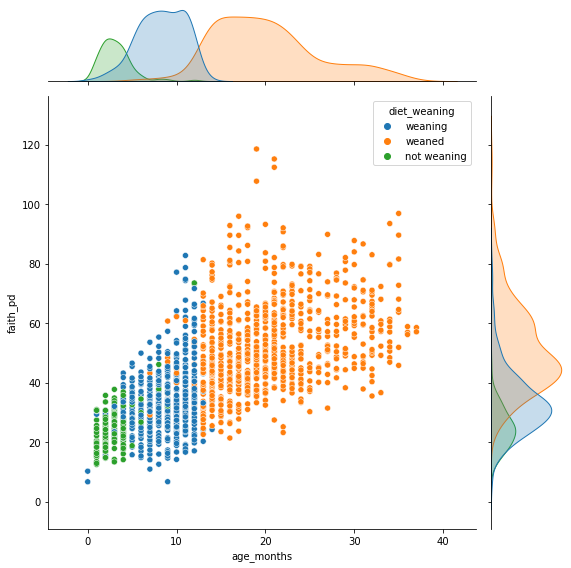

<Figure size 432x288 with 0 Axes>

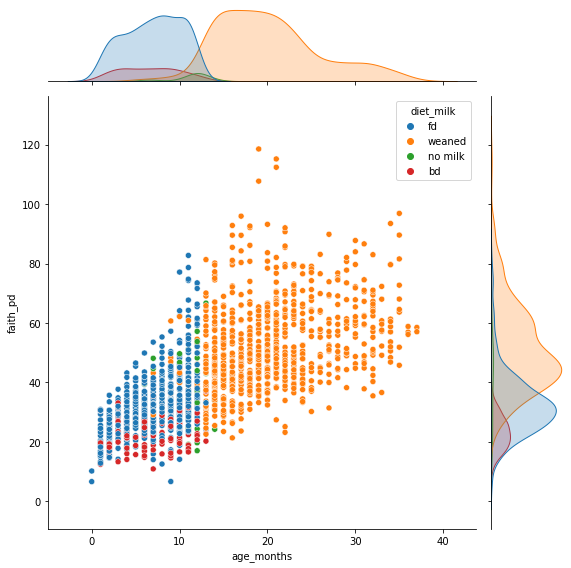

In [51]:
import seaborn as sns
# replace True/False with string
alpha_meta_weaning = alpha_meta
alpha_meta_weaning['diet_weaning'] = alpha_meta_weaning['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
# assume NaN means the baby is fully weaned
alpha_meta_weaning['diet_weaning'] = alpha_meta_weaning['diet_weaning'].fillna('weaned')
alpha_meta_weaning['diet_milk'] = alpha_meta_weaning['diet_milk'].fillna('weaned')

fig = plt.figure()
ax = sns.jointplot(data=alpha_meta_weaning, x="age_months", y="faith_pd", hue="diet_weaning",
             height = 8)
plt.savefig(data_dir+'/diet_weaning_age_jointplot.svg')
plt.show()

fig = plt.figure()
ax = sns.jointplot(data=alpha_meta_weaning, x="age_months", y="faith_pd", hue="diet_milk",
             height = 8)
plt.savefig(data_dir+'/diet_weaning_age_jointplot.svg')
plt.show()

## Check for normality

In [46]:
# Shapiro Wilk Test
from scipy.stats import shapiro
#using the methods from ex8
featuretable = q2.Artifact.load(f'{data_dir}/phylogeny_filtered_table.qza').view(pd.DataFrame)


In [47]:
featuretable.head()

,042c16e5b0f6444ef0466ba21a59fbd9,872a14c755bae7615bbfd082b4de20f9,35ffcc3b809d667286737d79670b8de5,118fbd65b0c5bdc8c2f12ef7099058aa,c6c3ab4e828fb40d6e05967b7aac9338,c180a36036d60eb85ccb62737d8e2ba0,c24e0e391aa836b5eae25567c7eb89ee,46953abeca4fce8a17c5dea8732f1611,8e175abe6a746b8f33bae9cd7c8192bb,315ca0a729f126b941ba111a16d4d97a,...,36f1f089e32373134ee77626ada1fbf0,78f2730a1c1c42f71e58763c6776ac77,ae290f0b0a5586b0cb783c2dfec83fa2,0f1803505db2f19f4b3067d768adf73b,b6645d333c70257fd3fe3dd42943189c,d01af41f6dac277a3feb79a1aa713c4b,9e27b12da68a87e509022323424d7b1b,c845eda99662b5a88a8c8e979ec07dd0,16abb37658f0d89cf9462696b61b312c,5f952448dbca288581e4b199a7db9178
ERR1309715,223.0,1537.0,141.0,320.0,935.0,3534.0,178.0,0.0,1852.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1309716,19.0,3346.0,12.0,2256.0,2288.0,974.0,1815.0,0.0,599.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1309717,246.0,3247.0,157.0,1203.0,2181.0,1202.0,830.0,0.0,636.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1309718,203.0,536.0,114.0,1306.0,310.0,2558.0,780.0,0.0,1245.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1309719,301.0,1527.0,223.0,202.0,923.0,2819.0,148.0,0.0,1511.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#check for if follow the normal distribution
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in featuretable.iteritems():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha

In [49]:
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


there's no normal distribution of the asvs, so we cannot use the anova and so on

## longitudinal analysis


In [8]:
#implementing beta diversity
! qiime longitudinal volatility \
  --m-metadata-file $data_dir/new_metadata_for_a_diversity.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/jaccard_pcoa_results.qza \
  --p-default-group-column 'diet_weaning'\
  --p-default-metric 'observed_features' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/core-metrics-results2/volatility_weaning_beta.qzv

Saved Visualization to: data/core-metrics-results2/volatility_weaning.qzv


In [ ]:
Visualization.load(f'{data_dir}/core-metrics-results2/volatility_weaning.qzv')

In [5]:
#implementing alpha diversity
! qiime longitudinal volatility \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/observed_features_vector.qza \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-default-group-column 'diet_weaning'\
  --p-default-metric 'observed_features' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/core-metrics-results2/volatility_weaning_alpha.qzv


Saved Visualization to: data/core-metrics-results2/volatility_weaning_alpha.qzv


In [ ]:
Visualization.load(f'{data_dir}/core-metrics-results2/volatility_weaning_alpha.qzv')

## Longitudinal analysis of age with zygosity or diet milk or diet weaning for faithpd and shannon entropy

### Zigosity

In [7]:
#zygosity
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')
#quantified statistics
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $or_dir/metadata.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'shannon_entropy~age_months*zygosity' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-shannon_zygosity.qzv

Saved Visualization to: data/lme-shannon_zygosity.qzv


In [9]:
Visualization.load(f'{data_dir}/lme-shannon_zygosity.qzv')

<visualization: Visualization uuid: 34f24d89-fe22-4657-8b55-d25c48dc1816>

In [6]:
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $or_dir/metadata.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'faith_pd~age_months*zygosity' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-faith_pd_zygosity.qzv

Saved Visualization to: data/lme-faith_pd_zygosity.qzv


In [10]:
Visualization.load(f'{data_dir}/lme-faith_pd_zygosity.qzv')

<visualization: Visualization uuid: cf6d13c8-788b-4dd8-bb35-361c3cd2d762>

### Diet_weaning

In [8]:
#diet_weaning
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'shannon_entropy~age_months*diet_weaning' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-shannon_dietweaning.qzv

Saved Visualization to: data/lme-shannon_dietweaning.qzv


In [11]:
Visualization.load(f'{data_dir}/lme-shannon_dietweaning.qzv')

<visualization: Visualization uuid: 7ae01b5f-2076-438b-8267-a258a3df5f6d>

In [11]:
#diet_weaning
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'faith_pd~age_months*diet_weaning' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-faith_pd_dietweaning.qzv

Saved Visualization to: data/lme-faith_pd_dietweaning.qzv


In [2]:
Visualization.load(f'{data_dir}/lme-faith_pd_dietweaning.qzv')

<visualization: Visualization uuid: 55dc9470-47e0-4f6c-9687-d2340c4d4625>

### Diet_milk

In [12]:
#diet_milk
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'shannon_entropy~age_months*diet_milk' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-shannon_dietmilk.qzv

Saved Visualization to: data/lme-shannon_dietmilk.qzv


In [13]:
Visualization.load(f'{data_dir}/lme-shannon_dietmilk.qzv')

<visualization: Visualization uuid: a09ab620-4cad-47d7-ac7b-6f2ac700f6f3>

In [13]:
#diet_milk
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'faith_pd~age_months*diet_milk' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-faith_pd_dietmilk.qzv

Saved Visualization to: data/lme-faith_pd_dietmilk.qzv


In [14]:
Visualization.load(f'{data_dir}/lme-faith_pd_dietmilk.qzv')

<visualization: Visualization uuid: 3c6cc686-08c9-4a3f-a2ba-74fbc30156b7>

### delivery mode

In [14]:
#delivery mode
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'shannon_entropy~age_months*delivery_mode' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-shannon_deliverymode.qzv

Saved Visualization to: data/lme-shannon_deliverymode.qzv


In [15]:
Visualization.load(f'{data_dir}/lme-shannon_deliverymode.qzv')

<visualization: Visualization uuid: 58cc75f3-50f5-4be6-887d-b9fca6aabe0e>

In [15]:
#delivery mode
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'faith_pd~age_months*delivery_mode' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-faith_pd_deliverymode.qzv

Saved Visualization to: data/lme-faith_pd_deliverymode.qzv


In [16]:
Visualization.load(f'{data_dir}/lme-faith_pd_deliverymode.qzv')

<visualization: Visualization uuid: 24641c90-644a-452e-a76a-8bcf33477006>

### delivery preterm

In [16]:
# delivery preterm
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/shannon_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'shannon_entropy~age_months*delivery_preterm' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-shannon_deliverypreterm.qzv

Saved Visualization to: data/lme-shannon_deliverypreterm.qzv


In [17]:
Visualization.load(f'{data_dir}/lme-shannon_deliverypreterm.qzv')

<visualization: Visualization uuid: 189e8ec3-b1b0-487e-bca9-d36005716852>

In [17]:
#delivery preterm
! qiime longitudinal linear-mixed-effects \
  --m-metadata-file $data_dir/metadata_fillna.tsv \
  --m-metadata-file $data_dir/core-metrics-results2/faith_pd_vector.qza \
  --p-random-effects 'age_months'\
  --p-formula 'faith_pd~age_months*delivery_preterm' \
  --p-state-column 'age_months' \
  --p-individual-id-column 'host_id' \
  --o-visualization $data_dir/lme-faith_pd_deliverypreterm.qzv

Saved Visualization to: data/lme-faith_pd_deliverypreterm.qzv


In [18]:
Visualization.load(f'{data_dir}/lme-faith_pd_deliverypreterm.qzv')

<visualization: Visualization uuid: 1ec01959-0889-4fcb-b0db-7434ac552fd5>

When try to do age_months* diet_milk * diet_weaning get non-singular matrix error, cannot calculate linear model as cannot invert the matrix. We tried removing the NaN values in the diet columns but this did not resolve the problem, this means those two variables are dependant and thus we cannot fit the longitudinal mixed effect analysis. 